<h1 style='text-align: center;'> Deep Learning Project 1 </h1> 
<h3 style='text-align: center;'> By Sri Das </h3>

<h2 style='text-align: center;'> Gender prediction through image classification </h2>

### Importing necessary packages

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import splitfolders

2023-02-05 18:24:55.092954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mypath = Path(os.path.abspath(""))

In [3]:
# Function to split image data into train and test folders
def split_data(input_dir, output_dir, x):
    splitfolders.ratio(input_dir, output = output_dir, seed = 1337, ratio = (x,1-x), group_prefix = None)

In [4]:
# Splitting image data : 90% for training and validation, 10% for testing
split_data(mypath /'celeb', mypath/'data_split',0.9)

In [5]:
train_path=mypath / "data_split/train"

In [8]:
# Creating a dataframe with image paths and lables as columns

female_dir = train_path / 'female'
male_dir = train_path /'male'

female_img = female_dir.glob('*.jpg')
male_img = male_dir.glob('*.jpg')

train_data = []
train_label = []

for img in female_img:
    train_data.append(str(img))
    train_label.append('female')
for img in male_img:
    train_data.append(str(img))
    train_label.append('male')
    
df = pd.DataFrame(train_data)
df.columns=['images']
df['labels'] = train_label

df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.shape

(3420, 2)

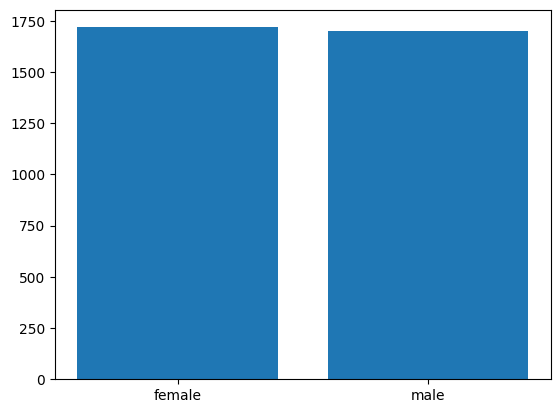

In [10]:
plt.bar(df['labels'].value_counts().index, df['labels'].value_counts().values)
plt.show()

#### Plotting a batch of sample images

In [11]:
image_batch = df.images[0:10]
label_batch = df.labels[0:10]

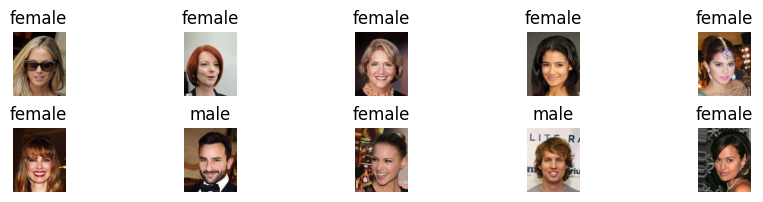

In [12]:
plt.figure(figsize=(10,2))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    img = cv2.imread(str(image_batch[i]))
    clr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(clr_img)
    plt.title(label_batch[i])
    plt.axis('off')
    #ax.autoscale(tight=False)
plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 0.5, wspace = 0.5)

### Model Building

In [13]:
FAST_RUN = True #False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [17]:
#Mapping the labels 
df['labels'] = df['labels'].replace({0:'female', 1:'male'})

#### Splitting data into train and valiadation sets

In [20]:
train_df, validate_df = train_test_split(df, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

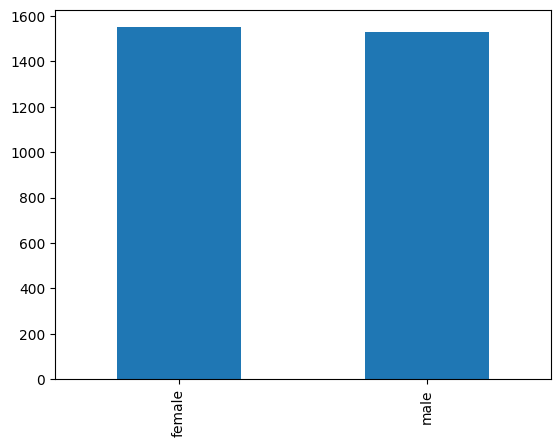

In [21]:
train_df['labels'].value_counts().plot.bar();

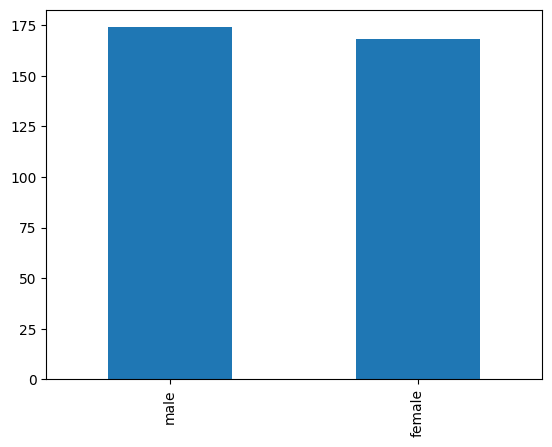

In [22]:
validate_df['labels'].value_counts().plot.bar();

In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

#### Training Generator

In [24]:
train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        '/Users/priyadas/Magnimind_mentorship/Proj1_deep_learn/data_split/train/',
        x_col='images',
        y_col = 'labels',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size = batch_size
)

Found 3078 validated image filenames belonging to 2 classes.


#### Validation Generator

In [25]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
        validate_df,
        '/Users/priyadas/Magnimind_mentorship/Proj1_deep_learn/data_split/train/',
        x_col = 'images',
        y_col = 'labels',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size

)

Found 342 validated image filenames belonging to 2 classes.


#### Generator Sample

In [26]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
        example_df,
        '/Users/priyadas/Magnimind_mentorship/Proj1_deep_learn/data_split/train/',
        x_col='images',
        y_col='labels',
        target_size=IMAGE_SIZE,
        class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


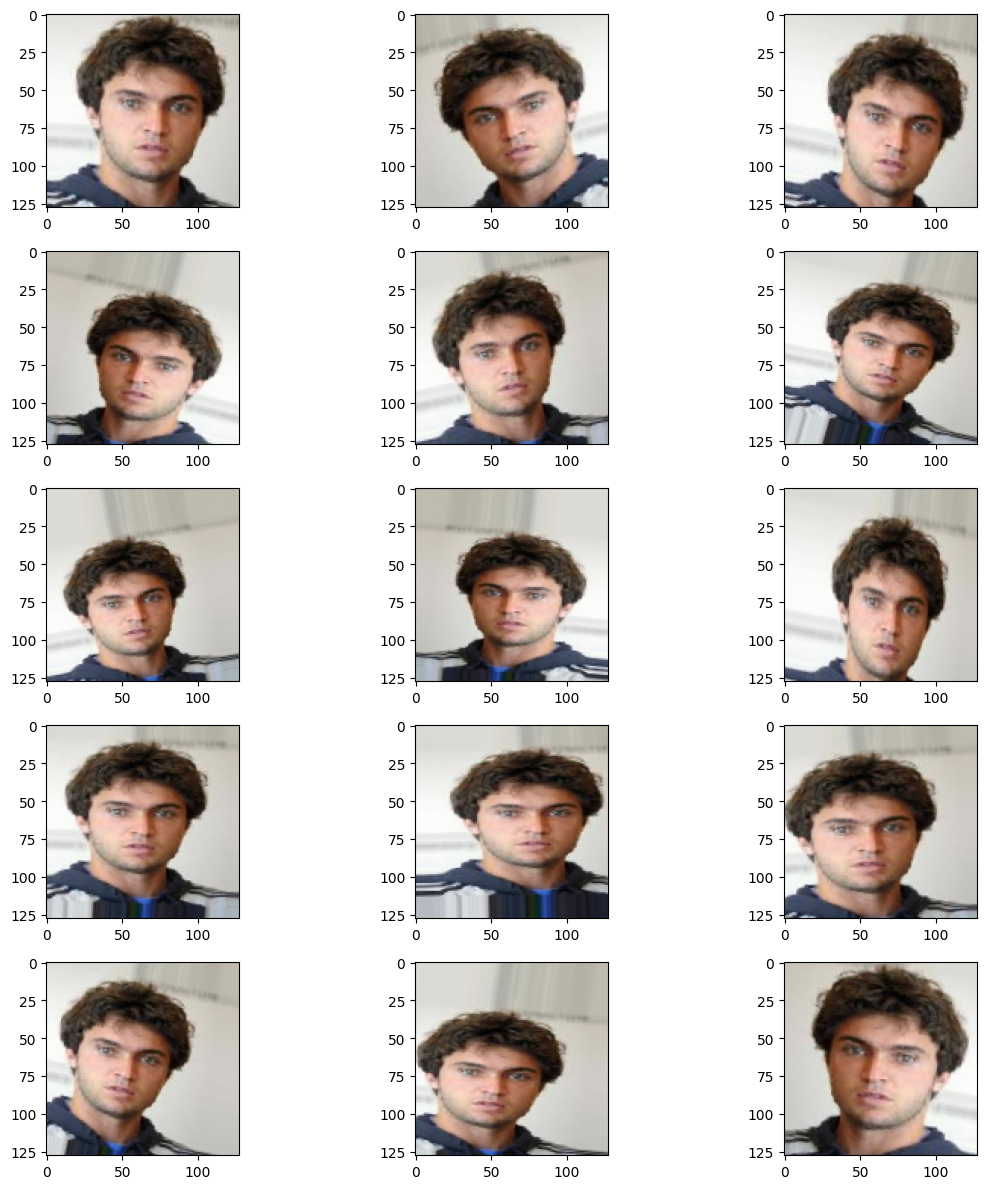

In [27]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the model

In [41]:
epochs=20 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20


/var/folders/77/x_rfm4m55m32vtc659sm8k_c0000gn/T/ipykernel_49455/4100386347.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


205/205 [==============================] - 41s 200ms/step - loss: 0.3197 - accuracy: 0.8707 - val_loss: 0.2775 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 2/20
205/205 [==============================] - 44s 216ms/step - loss: 0.3009 - accuracy: 0.8772 - val_loss: 0.3338 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 3/20
205/205 [==============================] - 46s 224ms/step - loss: 0.3023 - accuracy: 0.8769 - val_loss: 0.4178 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/20
205/205 [==============================] - 47s 227ms/step - loss: 0.3031 - accuracy: 0.8723 - val_loss: 0.2387 - val_accuracy: 0.9030 - lr: 0.0010
Epoch 5/20
205/205 [==============================] - 47s 229ms/step - loss: 0.3075 - accuracy: 0.8779 - val_loss: 0.2743 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 6/20
205/205 [==============================] - 47s 231ms/step - loss: 0.3037 - accuracy: 0.8750 - val_loss: 0.2868 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 7/20
205/205 [==============================] - 48s 232ms

In [42]:
# Saving the model
model.save_weights('model.h5')

#### Plotting the trainign loss and accuracy

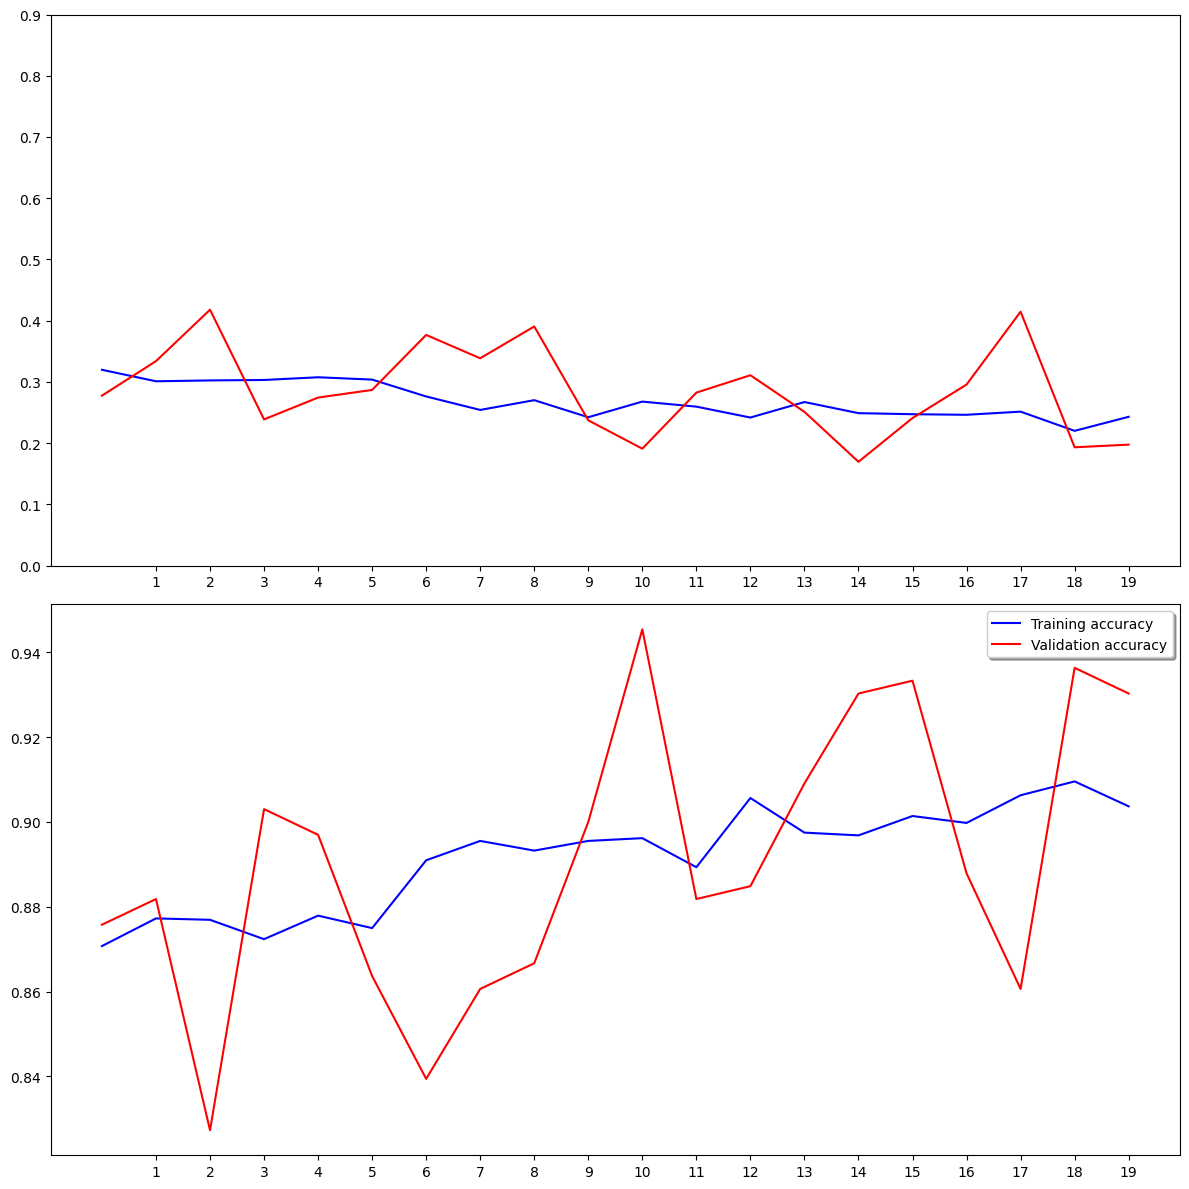

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
#legend = plt.legend(loc='best', shadow=True)


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
legend = plt.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

### Prediction

In [44]:
test_path=mypath / 'data_split/val'

In [45]:
# Creating a dataframe from the test data
test_female_dir = test_path / 'female'
test_male_dir = test_path /'male'

test_female_img = test_female_dir.glob('*.jpg')
test_male_img = test_male_dir.glob('*.jpg')

test_data = []
test_label = []

for img in test_female_img:
    test_data.append(str(img))
    test_label.append('female')
for img in test_male_img:
    test_data.append(str(img))
    test_label.append('male')
    
df_test = pd.DataFrame(test_data)
df_test.columns=['images']
df_test['labels'] = test_label

df_test = df_test.sample(frac=1).reset_index(drop=True)

#### Test Generator

In [46]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test, 
    "/Users/priyadas/Magnimind_mentorship/Proj1_deep_learn/data_split/val/", 
    x_col='images',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 381 validated image filenames.


In [47]:
nb_samples = df_test.shape[0]

In [48]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/var/folders/77/x_rfm4m55m32vtc659sm8k_c0000gn/T/ipykernel_49455/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [49]:
df_test['labels'] = np.argmax(predict, axis=-1)

In [50]:
label_map = dict((v,k) for k, v in train_generator.class_indices.items())
df_test['labels'] = df_test['labels'].replace(label_map)

In [51]:
df_test['labels'] = df_test['labels'].replace({'female':0, 'male':1})

<AxesSubplot: >

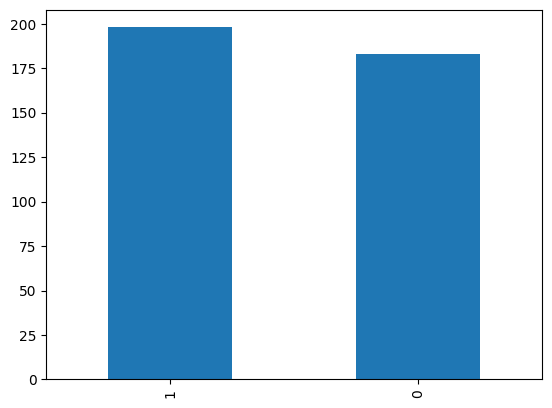

In [52]:
df_test['labels'].value_counts().plot.bar()

#### Plotting the predicted results

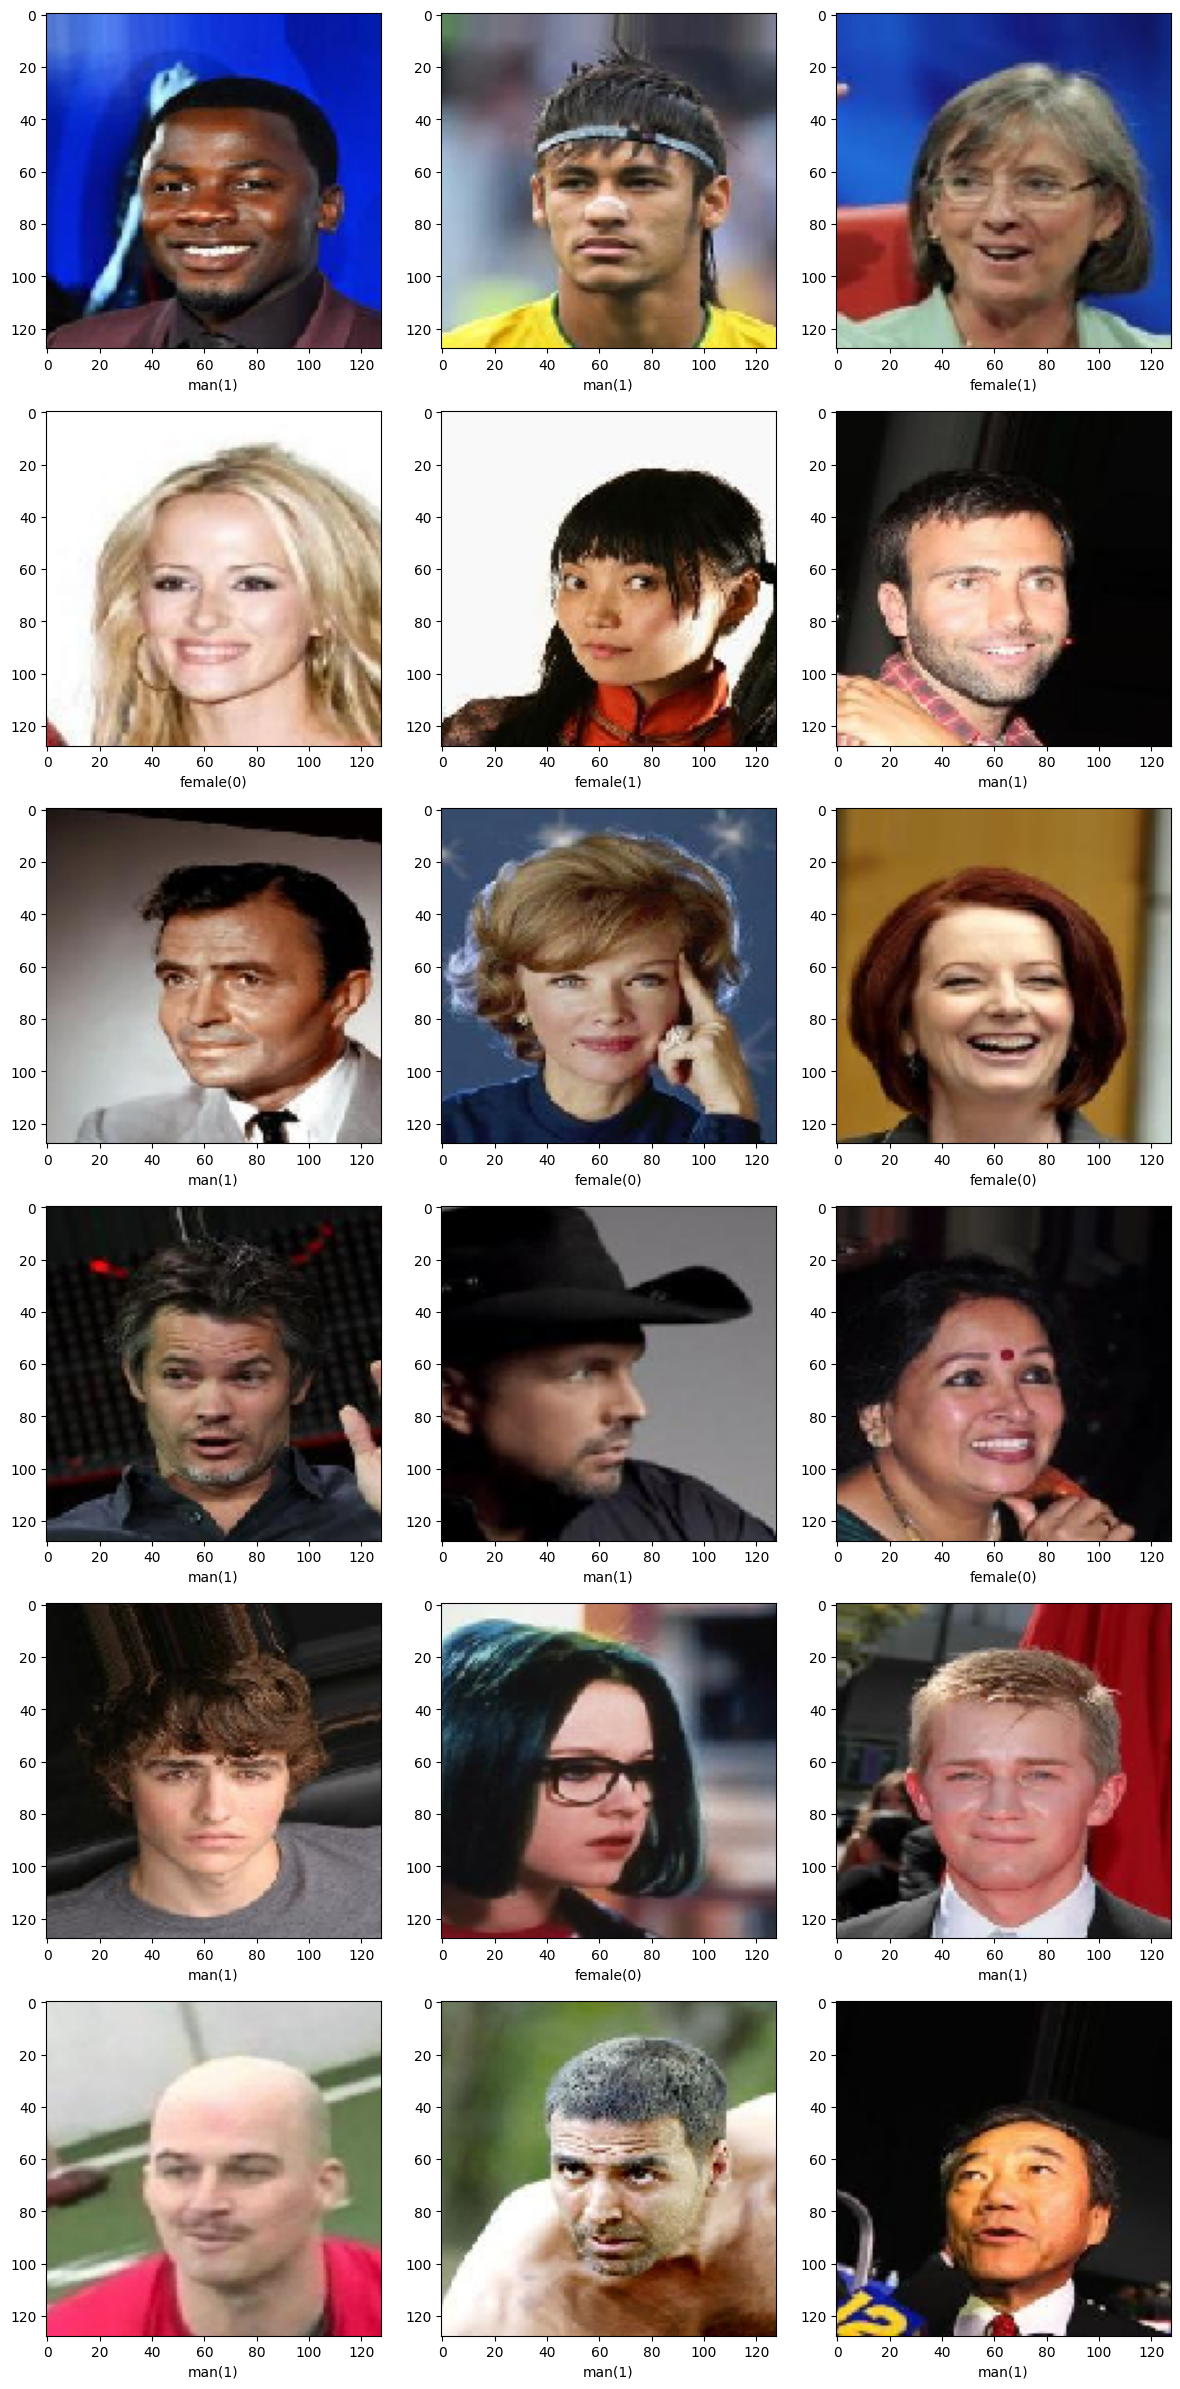

In [53]:
sample_test = df_test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['images']
    category = row['labels']
    img = load_img(filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename.split('/')[8].split('.')[0] + '(' + "{}".format(category) + ')' )
plt.tight_layout()
#plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 0.5, wspace = 0.5)
plt.show()